In [1]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import re 
import math
from pathlib import Path

This tutorial includes two sets of data files, in the data folder. Each set was generated with either a grid search, or a bisection search. We will go over processing these files to plot outputs. First we need to read the data files into lists, and select out the values we need.

In [2]:
#location of data
data = 'data/'

#Create list of all the files in the Bisections and GridSearch folders
#sort the files by the f value in the filename
bisectfiles = sorted(glob.glob(f'{data}Bisections/*.txt'), key=lambda x: 
                     float(Path(x).name.split('f')[1].split('_')[0]))
gridfiles = sorted(glob.glob(f'{data}GridSearch/*.txt'), key=lambda x: 
                   float(Path(x).name.split('f')[1].split('_')[0]))

#print('bisectfiles:', bisectfiles)
#print('gridfiles:', gridfiles)

#create lists to hold the data
bisectraw=[]
gridraw=[]

#read in the data for bisections
for txt in bisectfiles:
    with open(txt, 'r') as f:
        bisectraw.append(f.read())

#read in the data for grid searches
for txt in gridfiles:
    with open(txt, 'r') as f:
        gridraw.append(f.read())

#print('bisectraw:', bisectraw[1])
#print('gridraw:', gridraw[1])

In [3]:
#Select out the FAP and h values from the bisection data
#The FAP is in index 12 and the h value is in index 6
#We also need to pull out the frequency value for each file for later
#The frequency is in index 5

bisectfaplist = []
bisecthlist = []

for file in bisectraw:
        hlisttemp = []
        faplisttemp = []
        
        #read in the h and fap values
        for i in range(len(file.split('\n'))-1):
            #print(i)
            hlisttemp.append(float(file.split('\n')[i].split(',')[6]))
            faplisttemp.append(float(file.split('\n')[i].split(',')[12]))

        #Assign the values as a single index in the lists
        bisectfaplist.append(faplisttemp)
        bisecthlist.append(hlisttemp)

        #print('bisectfaplist:', bisectfaplist)
        #print('bisecthlist:', bisecthlist)


In [4]:
#Select out the FAP and h values from the grid search data
#The FAP is in index 12 and the h value is in index 6

gridfaplist = []
gridhlist = []
fgwlist = []

for file in gridraw:
        hlisttemp = []
        faplisttemp = []

        #read in the frequency values for later
        fgwlist.append(1e9 * 10**float(file.split('\n')[0].split(',')[5]))
        
        #read in the h and fap values
        for i in range(len(file.split('\n'))-1):
            #print(i)
            hlisttemp.append(float(file.split('\n')[i].split(',')[6]))
            faplisttemp.append(float(file.split('\n')[i].split(',')[12]))

        #Assign the values as a single index in the lists
        gridfaplist.append(faplisttemp)
        gridhlist.append(hlisttemp)
        
        #print('gridfaplist:', gridfaplist)
        #print('gridhlist:', gridhlist)

In [5]:
#Curate the bisection data by removing any FAP values of 0
#We can also set an upper and lower bound for the h values

lowbound = -16
upbound = -13

for i in range(len(bisecthlist)):
        file = zip(bisecthlist[i], bisectfaplist[i])
        hlisttemp = []
        faplisttemp = []
        #print('file:', file)

        for j in file:
            if j[1] != 0 and j[0] > lowbound and j[0] < upbound:
                hlisttemp.append(j[0])
                faplisttemp.append(j[1])
        bisecthlist[i] = hlisttemp
        bisectfaplist[i] = faplisttemp

#print('bisecthlist:', bisecthlist)
#print('bisectfaplist:', bisectfaplist)

In [6]:
#Curate the grid search data by removing any FAP values of 0
#We set our h bounds in the previous step, so we don't need to do that here

for i in range(len(gridhlist)):
        file = zip(gridhlist[i], gridfaplist[i])
        hlisttemp = []
        faplisttemp = []
        #print('file:', file)

        for j in file:
            if j[1] != 0 and j[0] > lowbound and j[0] < upbound:
                hlisttemp.append(j[0])
                faplisttemp.append(j[1])
        gridhlist[i] = hlisttemp
        gridfaplist[i] = faplisttemp

#print('gridhlist:', gridhlist)
#print('gridfaplist:', gridfaplist)

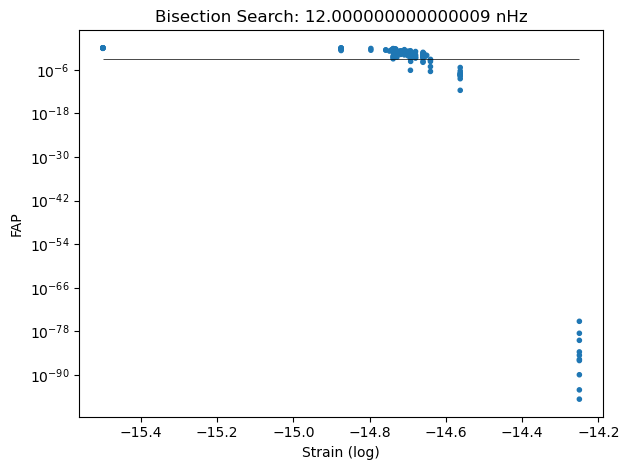

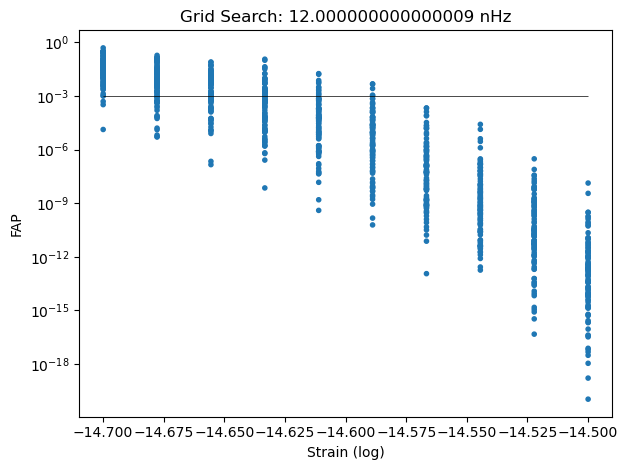

In [8]:
#For this example, we only want to plot one simulation.
#Index the simulation we want to plot
index = 4

#Find the minimum and maximum h values for the bisection and grid search data
#This will help us set the x axis limits for the plot
bxmin = min(bisecthlist[index])
bxmax = max(bisecthlist[index])
gxmin = min(gridhlist[index])
gxmax = max(gridhlist[index])

#These simulations were run using a detection threshold of 0.001. We will draw a line at this value
#on the plot to show where the FAP is below this value
threshold = 0.001

#Plot the bisection data for our selected simulation
plt.figure(1)
plt.yscale('log')
plt.ylabel('FAP')
plt.xlabel('Strain (log)')
plt.scatter(bisecthlist[index], bisectfaplist[index], marker='.', ls='')
plt.hlines(threshold, bxmin, bxmax, colors='0', linewidths = .5)
plt.title(f'Bisection Search: {fgwlist[index]} nHz')
plt.tight_layout();

#Plot the grid search data for our selected simulation
plt.figure(2)
plt.yscale('log')
plt.ylabel('FAP')
plt.xlabel('Strain (log)')
plt.scatter(gridhlist[index], gridfaplist[index], marker='.', ls='')
plt.hlines(threshold, gxmin, gxmax, colors='0', linewidths = .5)
plt.title(f'Grid Search: {fgwlist[index]} nHz')
plt.tight_layout();

In [9]:
#Generate two buckets for each frequency value from the grid search data
#The h-value bucket is the unique h values from the grid search data
#The fap bucket is the fraction of FAP values for each h that are below the threshold

reducedhlist = []
reducedfaplist = []

for fgw in range(len(gridhlist)):
    hbucket = []

    #Sift out the unique h values and place them in hbucket
    for i in gridhlist[fgw]:
        if np.where(np.array(hbucket) == i)[0].size == 0:
            hbucket.append(i)

    fapbucket = []

    #For each unique h value, find the index of that value in the gridhlist
    for i in hbucket:

        #index will be a list of the indices of the unique h value in the gridhlist
        index = np.where(np.array(gridhlist[fgw]) == i)[0]
        length = len(index)
        count = 0
        
        #For each index, check if the FAP value is below the threshold
        #If it is, add 1 to the count
        for j in index:
            if gridfaplist[fgw][j] <= threshold:
                count += 1

        #Append the fraction of FAP values that are below the threshold to the fapbucket
        fapbucket.append(count/length)

    #Append the hbucket and fapbucket to the reducedhlist and reducedfaplist
    reducedhlist.append(hbucket)
    reducedfaplist.append(fapbucket)

#print('reducedhlist:', reducedhlist)
#print('reducedfaplist:', reducedfaplist)
    

In [10]:
accuracy = .95
hthreshold = []

for i in range(len(reducedhlist)):
    
    for j in range(len(reducedfaplist[i])):
        if reducedfaplist[i][j] > accuracy:
            hthreshold.append(reducedhlist[i][j])
            break

print('hthreshold:', hthreshold)


hthreshold: [-14.366666666666667, -14.455555555555556, -14.5, -14.551111111111112, -14.566666666666666, -14.61111111111111, -14.622222222222222, -14.616666666666667, -14.63888888888889, -14.63888888888889, -14.633333333333333, -14.616666666666667, -14.616666666666667, -14.438888888888888, -13.166666666666666, -14.544444444444444, -14.588888888888889, -14.588888888888889]


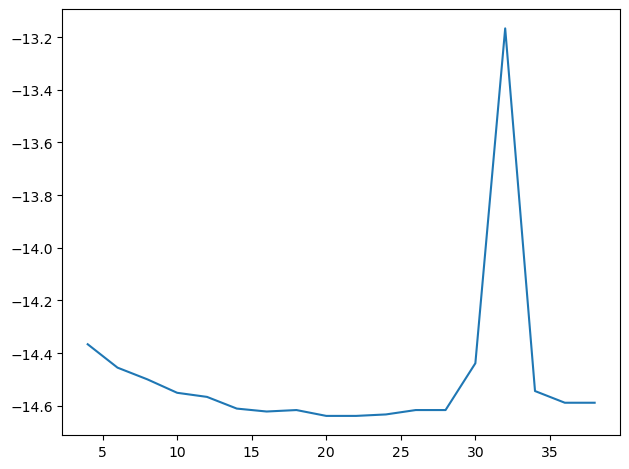

In [13]:
plt.plot(fgwlist, hthreshold)
plt.tight_layout();